<h1 style="color:purple">Rice Leaf Disease Detection</h1>


For this project ,our approch is to detecting rice leaf disease by using CNN(convulation nnueral network),which are a type of deep learning algorithm that can learn to recognize patterns in images.
This dataset consist of 119jpg images. we provide 3 type of leaf to out model and model detect & serve result

<h2 style="color:purple">Importing the libraries </h2>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


<h2 style="color:purple"> Set all the Constants</h2>

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

<h2 style="color:purple">Import data into tensorflow dataset object</h2>

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory('Riceleaf') 

Found 119 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 1 0 1 1 1 2 0 0 2 2 1 1 2 2 0 0 0 2 1 0 1 1 1 1 2 2 1 1 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

<h2 style="color:purple"> Visualize some of the images from our dataset</h2>

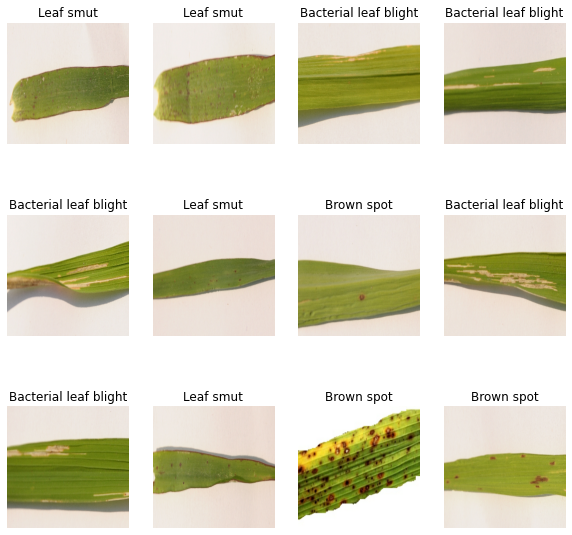

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<h2 style="color:purple">Function to Split Dataset</h2>

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

2

In [17]:
len(val_ds)

0

In [18]:
len(test_ds)

2

<h2 style="color:purple">Cache, Shuffle, and Prefetch the Dataset</h2>

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h2 style="color:purple">Building the Model</h2>

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

<h2 style="color:purple">Data Augmentation</h2>
 
 
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

<h2 style="color:purple">Applying Data Augmentation to Train Dataset</h2>

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



<h2 style="color:purple"> Model Architecture</h2>

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

<h2 style="color:purple"> Compiling the Model</h2>

We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/50
2/2 [==============================] - 4s 1s/step - loss: 1.1098 - accuracy: 0.2364
Epoch 2/50
2/2 [==============================] - 2s 758ms/step - loss: 1.1037 - accuracy: 0.2909
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 1.0998 - accuracy: 0.3636
Epoch 4/50
2/2 [==============================] - 2s 668ms/step - loss: 1.0952 - accuracy: 0.3636
Epoch 5/50
2/2 [==============================] - 2s 695ms/step - loss: 1.0947 - accuracy: 0.3636
Epoch 6/50
2/2 [==============================] - 2s 930ms/step - loss: 1.1080 - accuracy: 0.3636
Epoch 7/50
2/2 [==============================] - 2s 702ms/step - loss: 1.1024 - accuracy: 0.3818
Epoch 8/50
2/2 [==============================] - 2s 963ms/step - loss: 1.0894 - accuracy: 0.3636
Epoch 9/50
2/2 [==============================] - 2s 1s/step - loss: 1.0902 - accuracy: 0.3818
Epoch 10/50
2/2 [==============================] - 2s 1s/step - loss: 1.0864 - accuracy: 0.3818
Epoch 11/50
2/2 [==============

In [27]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 225ms/step - loss: 0.5967 - accuracy: 0.7818


**You can see above that we get 78% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [28]:
scores

[0.5966857671737671, 0.7818182110786438]

Scores is just a list containing loss and accuracy value

<h2 style="color:purple"> Plotting the Accuracy and Loss Curves</h2>

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 2}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1098052263259888,
 1.103651523590088,
 1.0998467206954956,
 1.0952180624008179,
 1.0947399139404297]

<h2 style="color:purple"> Run prediction on a sample image</h2>

first image to predict
actual label: Brown spot
1/1 [==============================] - 0s 417ms/step
predicted label: Bacterial leaf blight


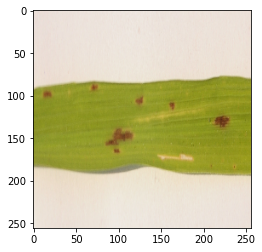

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

<h2 style="color:purple"> Write a function for inference</h2>

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 29ms/step


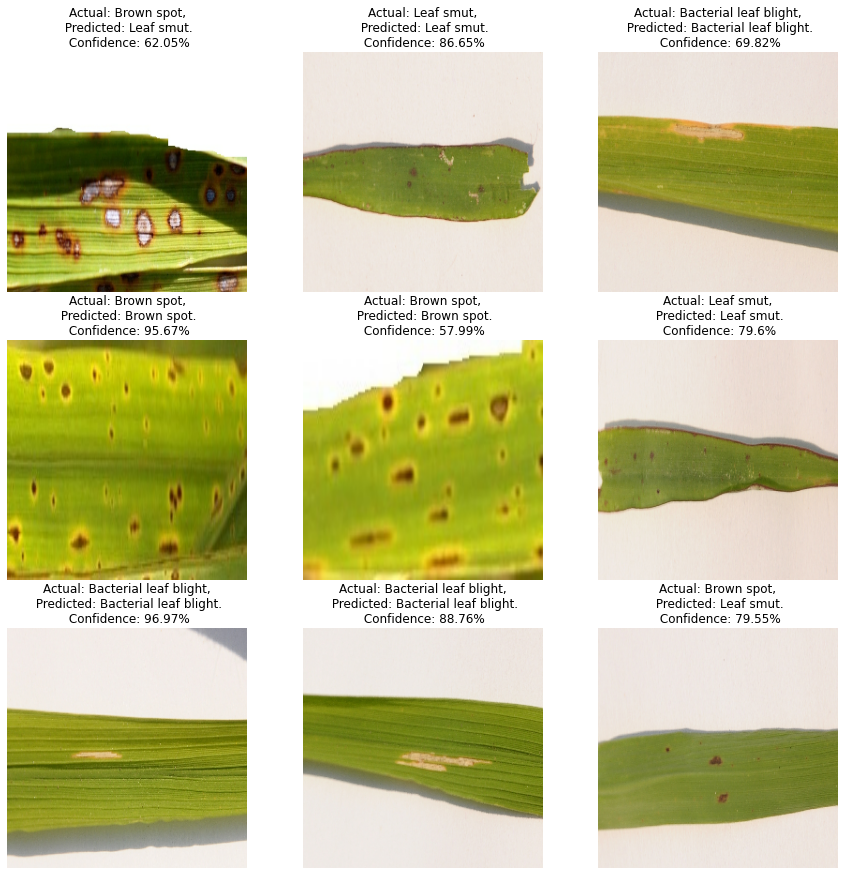

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")